In [1]:
import os
import pandas as pd

ggi_dir = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/3-string_ppi_data"
go_dir  = "/opt/ai4g_chriszyyang/buddy1/2_project_ongoing/4-antibio_resistance/PANACEA/data/4-go_annotation"

# 1. 找到两个目录下共同存在的菌株文件夹
ggi_strains = {d for d in os.listdir(ggi_dir)
               if os.path.isdir(os.path.join(ggi_dir, d))}
go_strains = {d for d in os.listdir(go_dir)
              if os.path.isdir(os.path.join(go_dir, d))}

common_strains = sorted(ggi_strains & go_strains)
print(f"Found {len(common_strains)} common strains.")

results = []

for strain in common_strains:
    go_file  = os.path.join(go_dir,  strain, f"{strain}.go_raw.tsv")
    ggi_file = os.path.join(ggi_dir, strain, f"{strain}.ggi.in_genes.tsv")

    if not os.path.exists(go_file) or not os.path.exists(ggi_file):
        print(f"[WARN] Missing file for {strain}, skip.")
        continue

    # 2. 读取数据
    df_go  = pd.read_csv(go_file, sep="\t")
    df_ggi = pd.read_csv(ggi_file, sep="\t")

    # 3. 有 GO 注释的基因集合
    go_genes = set(df_go["Genes"].astype(str).unique())

    # 4. ggi 中出现的所有 unique genes（gene1 ∪ gene2）
    ggi_genes = set(df_ggi["gene1"].astype(str)) | set(df_ggi["gene2"].astype(str))

    # 5. 计算覆盖率
    num_ggi_genes = len(ggi_genes)
    num_annotated = len(ggi_genes & go_genes)
    coverage = num_annotated / num_ggi_genes if num_ggi_genes > 0 else float("nan")

    results.append({
        "strain": strain,
        "n_ggi_genes": num_ggi_genes,
        "n_annotated_genes": num_annotated,
        "coverage": coverage
    })

# 6. 汇总结果
df_cov = pd.DataFrame(results).sort_values("coverage", ascending=False)

df_cov.to_csv("ggi_go_coverage_summary.tsv", sep="\t", index=False)
print("Saved to ggi_go_coverage_summary.tsv")

Found 86 common strains.
Saved to ggi_go_coverage_summary.tsv


In [2]:
df_cov.head()

,strain,n_ggi_genes,n_annotated_genes,coverage
31,Corynebacterium_diphtheriae_FRC0024,14,14,1.000000
80,Enterococcus_faecium_1603468,381,378,0.992126
62,Enterococcus_faecalis_13-2-16,403,398,0.987593
79,Enterococcus_faecalis_V583,387,382,0.987080
65,Enterococcus_faecalis_AR-0780,404,398,0.985149


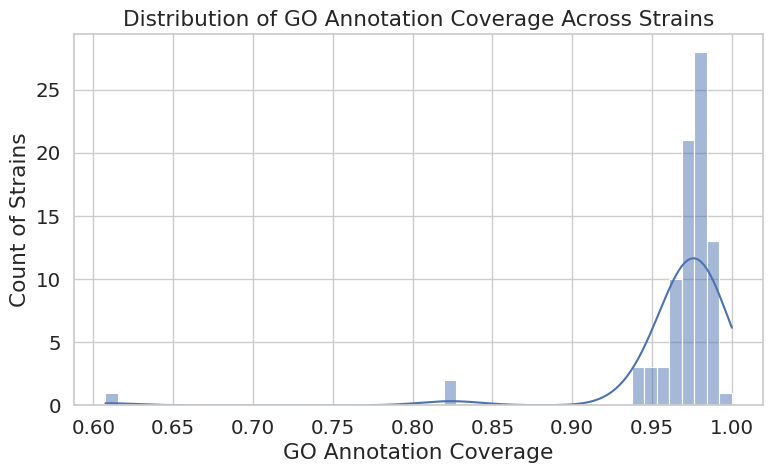

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.3)

plt.figure(figsize=(8, 5))
sns.histplot(df_cov["coverage"], kde=True, bins=50)

plt.xlabel("GO Annotation Coverage")
plt.ylabel("Count of Strains")
plt.title("Distribution of GO Annotation Coverage Across Strains")
plt.tight_layout()
plt.show()